## Crowdedness Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os

Read event log from CSV file and analyze the crowdedness of the event.

In [4]:

log_file = "./filtered_mimicel.csv"
df = pd.read_csv(log_file)
df.head()

,stay_id,subject_id,hadm_id,timestamps,activity,gender,race,arrival_transport,disposition,seq_num,...,rhythm,name,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn,los
0,30000012,11714491,21562392.0,2126-02-14 20:22:00,Enter the ED,F,WHITE,AMBULANCE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,11714491,21562392.0,2126-02-14 20:22:01,Triage in the ED,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,spironolactone,6818.0,1.672902e+10,2.0,6043.0,Aldosterone Receptor Antagonists,NaN,NaN,NaN
3,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,spironolactone,6818.0,1.672902e+10,1.0,5658.0,"Diuretic - Aldosterone Receptor Antagonist, No...",NaN,NaN,NaN
4,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,rifaximin,66295.0,5.486862e+10,1.0,5844.0,Rifamycins and Related Derivative Antibiotics,NaN,NaN,NaN


In [5]:
df['timestamps'] = pd.to_datetime(df['timestamps'])

df_entry = df.loc[df['activity'] == 'Enter the ED'][['stay_id','timestamps','arrival_transport']]
df_entry.columns = ['stay_id','enter_time','arrival_transport']

df_discharge = df.loc[df['activity'] == 'Discharge from the ED'][['stay_id','timestamps','disposition']].drop_duplicates()
df_discharge.columns = ['stay_id','discharge_time','disposition']

df_ed = df_entry.merge(df_discharge, on = 'stay_id')
df_ed.head()


,stay_id,enter_time,arrival_transport,discharge_time,disposition
0,30000012,2126-02-14 20:22:00,AMBULANCE,2126-02-15 01:59:00,ADMITTED
1,30000017,2185-06-18 11:51:00,WALK IN,2185-06-18 15:53:00,ELOPED
2,30000038,2152-12-07 16:37:00,AMBULANCE,2152-12-07 19:55:00,ADMITTED
3,30000039,2165-10-06 11:47:00,WALK IN,2165-10-06 20:18:00,ADMITTED
4,30000055,2155-07-18 17:03:00,WALK IN,2155-07-18 21:12:00,HOME


#### Crowdedness

We define the crowdedness experienced by a patient (identified by the `stay_id`) as the number of patients simultaneously treated along with him at the ED.

We consider patient `B` is treated simultaneously with patient `A`, if `B's discharge time >= A's Entry time & B's entry time <= A's discharge time`

In [6]:
df_ed_b = df_ed.copy()[['stay_id','enter_time','discharge_time']]

In [ ]:
#computation of crowdedness
df_ed['crowdedness'] = df_ed.apply(lambda row: len(df_ed_b[(df_ed_b['enter_time'] <= row['discharge_time']) & (df_ed_b['discharge_time'] >=  row['enter_time']) ]), axis=1)

In [ ]:
df_ed.to_csv("./mimicel_crowdedness.csv")

##### Distribution of the number of patients based on the experienced crowdedness

In [5]:
df_ed = pd.read_csv("./mimicel_crowdedness.csv").iloc[:,1:]
df_ed['enter_time'] = pd.to_datetime(df_ed['enter_time'])
df_ed['discharge_time'] = pd.to_datetime(df_ed['discharge_time'])
df_ed.head()

,stay_id,enter_time,arrival_transport,discharge_time,disposition,crowdedness
0,30000012,2126-02-14 20:22:00,AMBULANCE,2126-02-15 01:59:00,ADMITTED,11
1,30000017,2185-06-18 11:51:00,WALK IN,2185-06-18 15:53:00,ELOPED,11
2,30000038,2152-12-07 16:37:00,AMBULANCE,2152-12-07 19:55:00,ADMITTED,18
3,30000039,2165-10-06 11:47:00,WALK IN,2165-10-06 20:18:00,ADMITTED,13
4,30000055,2155-07-18 17:03:00,WALK IN,2155-07-18 21:12:00,HOME,10


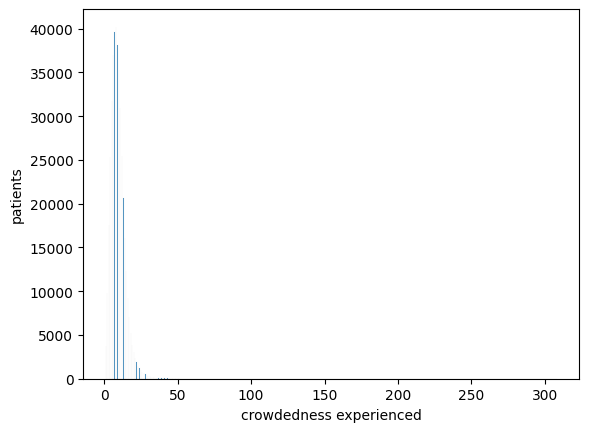

In [6]:
sn.histplot(df_ed['crowdedness'],kde=False)

# Add labels and legend
plt.xlabel("crowdedness experienced")
plt.ylabel("patients")
plt.show()

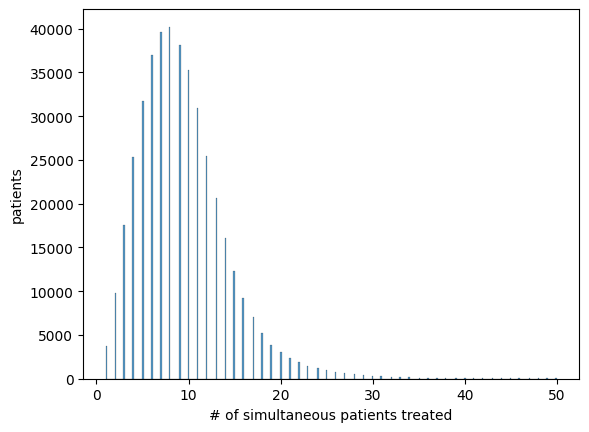

In [7]:
sn.histplot(df_ed.loc[df_ed['crowdedness'] <= 50,'crowdedness'],kde=False)

# Add labels and legend
plt.xlabel("# of simultaneous patients treated")
plt.ylabel("patients")
plt.show()

Text(0.5, 1.0, 'los vs crowdedness')

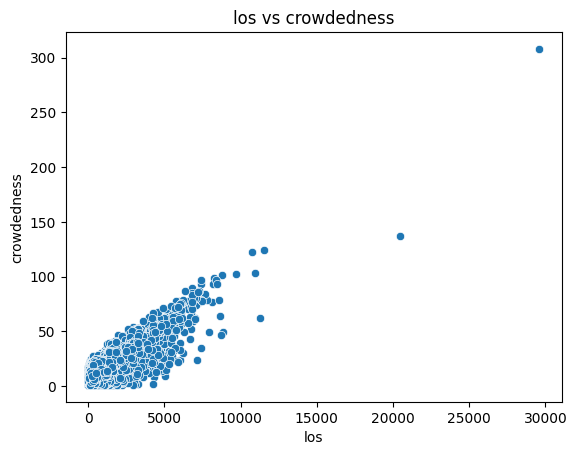

In [9]:
#crowdedness vs los
df_ed['los'] =round(( df_ed['discharge_time'] - df_ed['enter_time']).dt.total_seconds() / 60,0)
sn.scatterplot(data=df_ed, x='los', y='crowdedness')

# Add labels and title to the plot
plt.xlabel('los')
plt.ylabel('crowdedness')
plt.title('los vs crowdedness')

Text(0.5, 1.0, 'los vs crowdedness - long los')

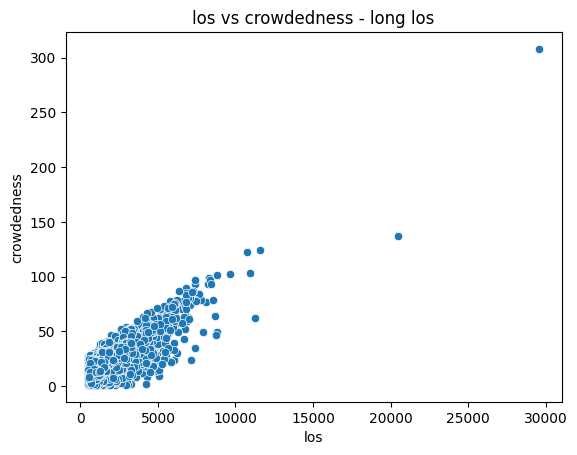

In [10]:
#crowdedness vs los in long los cohort
df_t = df_ed.loc[df_ed['los'] >= df_ed['los'].quantile(0.75)]
sn.scatterplot(data=df_t, x='los', y='crowdedness')

# Add labels and title to the plot
plt.xlabel('los')
plt.ylabel('crowdedness')
plt.title('los vs crowdedness - long los')

##### Generating the Eventlog with the Information about crowdedness

In [11]:
#label the stay_id based on the los and crowdedness. We consider being > 75th percentile to be high los/ high crowdedness

df_ed['los_label'] = 'normal'
df_ed['cr_label'] = 'normal'

df_ed.loc[df_ed['los'] >= df_ed['los'].quantile(0.75), 'los_label'] = 'long'
df_ed.loc[df_ed['crowdedness'] >= df_ed['crowdedness'].quantile(0.75), 'cr_label'] = 'high'

In [12]:
df_crowdedness = df_ed.merge(df[['stay_id','timestamps','activity']], on = 'stay_id')
df_crowdedness.to_csv("./mimicel_with_crowdedness.csv")



In [13]:
df_crowdedness.loc[df_crowdedness['cr_label'] == 'normal'].to_csv("./mimicel_with_crowdedness_normal.csv")
df_crowdedness.loc[df_crowdedness['cr_label'] != 'normal'].to_csv("./mimicel_with_crowdedness_high.csv")

##### Analysis of effect of crowdedness towards the certain activitiy durations

In [14]:
df_act = df[['stay_id','timestamps','activity']].drop_duplicates()
df_act['activity_index'] = df_act.groupby('stay_id')['timestamps'].rank(ascending=True)
df_act.head()

,stay_id,timestamps,activity,activity_index
0,30000012,2126-02-14 20:22:00,Enter the ED,1.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,2.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,4.0
11,30000012,2126-02-14 23:43:00,Vital sign check,5.0


In [15]:
df_act['activity_index_next'] = df_act['activity_index']-1
df_loops = df_act.merge(df_act, left_on = ['stay_id','activity_index'],right_on =  ['stay_id','activity_index_next'], how = 'left')
df_loops.head()

,stay_id,timestamps_x,activity_x,activity_index_x,activity_index_next_x,timestamps_y,activity_y,activity_index_y,activity_index_next_y
0,30000012,2126-02-14 20:22:00,Enter the ED,1.0,0.0,2126-02-14 20:22:01,Triage in the ED,2.0,1.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,2.0,1.0,2126-02-14 22:21:00,Medicine reconciliation,3.0,2.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,2.0,2126-02-14 22:22:00,Medicine reconciliation,4.0,3.0
3,30000012,2126-02-14 22:22:00,Medicine reconciliation,4.0,3.0,2126-02-14 23:43:00,Vital sign check,5.0,4.0
4,30000012,2126-02-14 23:43:00,Vital sign check,5.0,4.0,2126-02-15 00:16:00,Medicine reconciliation,6.0,5.0


In [16]:
df_loops = df_loops[['stay_id', 'timestamps_x', 'activity_x', 'activity_index_x',
       'timestamps_y', 'activity_y']]
df_loops.columns =  ['stay_id', 'timestamps', 'activity', 'activity_index',
       'timestamps_next', 'activity_next']

df_loops = df_loops.merge(df_ed, on = 'stay_id')  
  

In [17]:
df_loops.head()   

,stay_id,timestamps,activity,activity_index,timestamps_next,activity_next,enter_time,arrival_transport,discharge_time,disposition,crowdedness,los,los_label,cr_label
0,30000012,2126-02-14 20:22:00,Enter the ED,1.0,2126-02-14 20:22:01,Triage in the ED,2126-02-14 20:22:00,AMBULANCE,2126-02-15 01:59:00,ADMITTED,11,337.0,normal,normal
1,30000012,2126-02-14 20:22:01,Triage in the ED,2.0,2126-02-14 22:21:00,Medicine reconciliation,2126-02-14 20:22:00,AMBULANCE,2126-02-15 01:59:00,ADMITTED,11,337.0,normal,normal
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,2126-02-14 22:22:00,Medicine reconciliation,2126-02-14 20:22:00,AMBULANCE,2126-02-15 01:59:00,ADMITTED,11,337.0,normal,normal
3,30000012,2126-02-14 22:22:00,Medicine reconciliation,4.0,2126-02-14 23:43:00,Vital sign check,2126-02-14 20:22:00,AMBULANCE,2126-02-15 01:59:00,ADMITTED,11,337.0,normal,normal
4,30000012,2126-02-14 23:43:00,Vital sign check,5.0,2126-02-15 00:16:00,Medicine reconciliation,2126-02-14 20:22:00,AMBULANCE,2126-02-15 01:59:00,ADMITTED,11,337.0,normal,normal


In [18]:
df_loops['loop_len'] = round(( df_loops['timestamps_next'] -df_loops['timestamps']).dt.total_seconds() / 60,0)
df_loops.head()


,stay_id,timestamps,activity,activity_index,timestamps_next,activity_next,enter_time,arrival_transport,discharge_time,disposition,crowdedness,los,los_label,cr_label,loop_len
0,30000012,2126-02-14 20:22:00,Enter the ED,1.0,2126-02-14 20:22:01,Triage in the ED,2126-02-14 20:22:00,AMBULANCE,2126-02-15 01:59:00,ADMITTED,11,337.0,normal,normal,0.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,2.0,2126-02-14 22:21:00,Medicine reconciliation,2126-02-14 20:22:00,AMBULANCE,2126-02-15 01:59:00,ADMITTED,11,337.0,normal,normal,119.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,2126-02-14 22:22:00,Medicine reconciliation,2126-02-14 20:22:00,AMBULANCE,2126-02-15 01:59:00,ADMITTED,11,337.0,normal,normal,1.0
3,30000012,2126-02-14 22:22:00,Medicine reconciliation,4.0,2126-02-14 23:43:00,Vital sign check,2126-02-14 20:22:00,AMBULANCE,2126-02-15 01:59:00,ADMITTED,11,337.0,normal,normal,81.0
4,30000012,2126-02-14 23:43:00,Vital sign check,5.0,2126-02-15 00:16:00,Medicine reconciliation,2126-02-14 20:22:00,AMBULANCE,2126-02-15 01:59:00,ADMITTED,11,337.0,normal,normal,33.0


Text(0, 0.5, 'simultaneous patients')

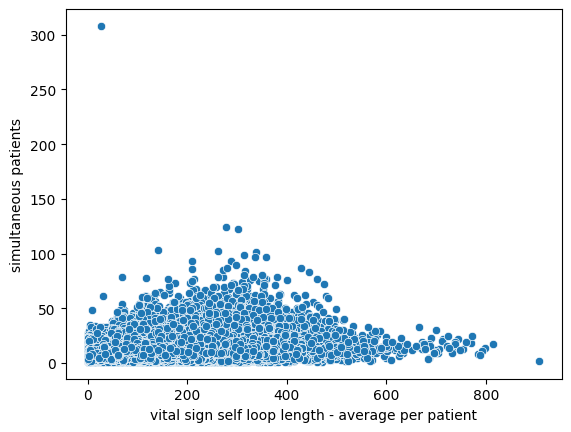

In [19]:
#crowdedness vs vital sign self loop

df_t = df_loops.loc[(df_loops['activity'] == 'Vital sign check') & (df_loops['activity_next'] == 'Vital sign check') ]
df_t = df_t.groupby(['stay_id','crowdedness'])['loop_len'].mean().reset_index()
sn.scatterplot(data=df_t, x='loop_len', y='crowdedness')

# Add labels and title to the plot
plt.xlabel('vital sign self loop length - average per patient')
plt.ylabel('simultaneous patients')


Text(0, 0.5, 'simultaneous patients')

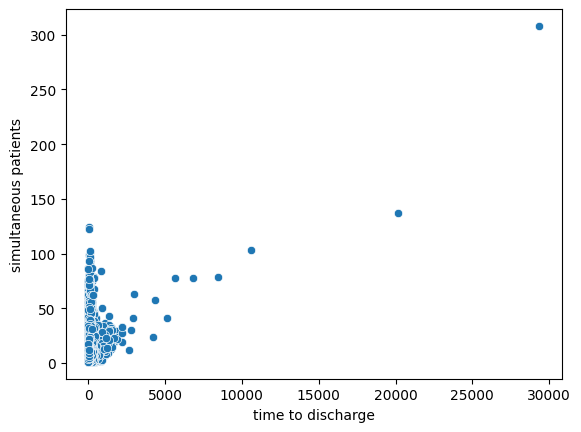

In [20]:
#crowdedness vs discharge time

df_t = df_loops.loc[(df_loops['activity'] != 'Discharge from the ED') & (df_loops['activity_next'] == 'Discharge from the ED') ]
sn.scatterplot(data=df_t, x='loop_len', y='crowdedness')

# Add labels and title to the plot
plt.xlabel('time to discharge')
plt.ylabel('simultaneous patients')

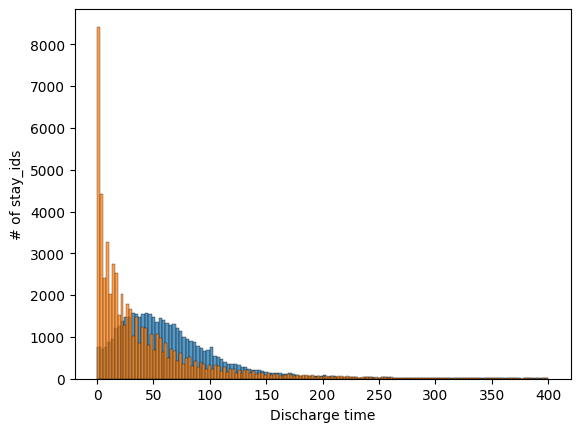

In [21]:
#distribution of admitted vs home cohorts in terms of discharge loop length
df_t = df_loops.loc[(df_loops['activity'] != 'Discharge from the ED') & (df_loops['activity_next'] == 'Discharge from the ED') & (df_loops['cr_label'] == 'high') & (df_loops['loop_len'] <= 400)  ]
#check the two distributions in terms of crowdedness
sn.histplot(df_t.loc[df_t['disposition'] == 'ADMITTED' ,'loop_len'],kde=False, label = 'Admitted')
sn.histplot(df_t.loc[df_t['disposition'] == 'HOME' ,'loop_len'],kde=False, label = 'Home')

# Add labels and legend
plt.xlabel("Discharge time")
plt.ylabel("# of stay_ids")
plt.show()

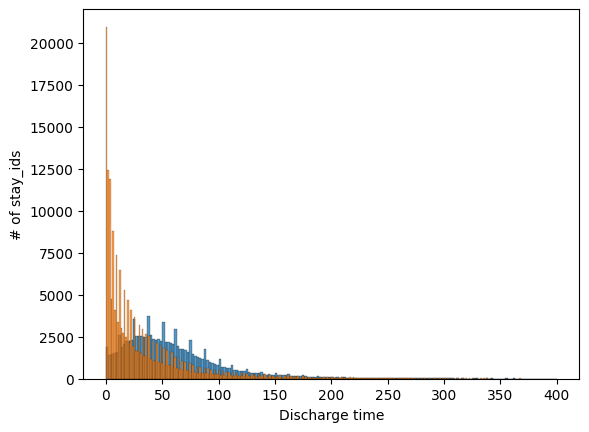

In [22]:
#distribution of admitted vs home cohorts in terms of discharge loop length
df_t = df_loops.loc[(df_loops['activity'] != 'Discharge from the ED') & (df_loops['activity_next'] == 'Discharge from the ED') & (df_loops['cr_label'] == 'normal') & (df_loops['loop_len'] <= 400)  ]
#check the two distributions in terms of crowdedness
sn.histplot(df_t.loc[df_t['disposition'] == 'ADMITTED' ,'loop_len'],kde=False, label = 'Admitted')
sn.histplot(df_t.loc[df_t['disposition'] == 'HOME' ,'loop_len'],kde=False, label = 'Home')

# Add labels and legend
plt.xlabel("Discharge time")
plt.ylabel("# of stay_ids")
plt.show()

<ipython-input-23-f81ddae21044>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t1['group'] = 'Normal'
<ipython-input-23-f81ddae21044>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2['group'] = 'Crowded'


Text(0.5, 1.0, 'Discharge length by Disposition method')

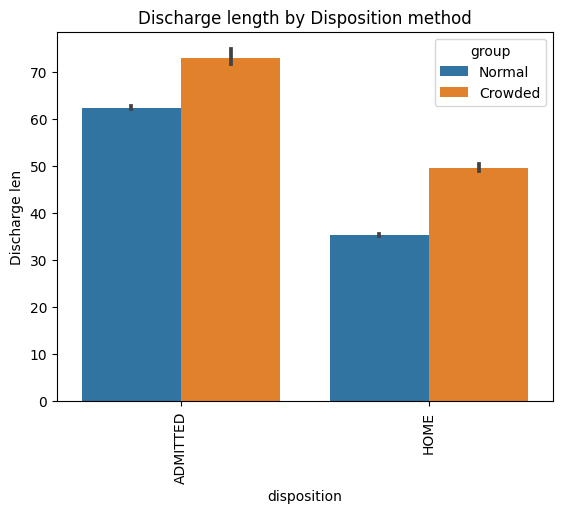

In [23]:
df_t1 = df_loops.loc[(df_loops['activity'] != 'Discharge from the ED') & (df_loops['activity_next'] == 'Discharge from the ED') & (df_loops['cr_label'] == 'normal')]
df_t1.groupby('disposition')['loop_len'].median().reset_index()

df_t2 = df_loops.loc[(df_loops['activity'] != 'Discharge from the ED') & (df_loops['activity_next'] == 'Discharge from the ED') & (df_loops['cr_label'] == 'high')]
df_t2.groupby('disposition')['loop_len'].median().reset_index()

df_t1['group'] = 'Normal'
df_t2['group'] = 'Crowded'

# Merge the two DataFrames
merged_df = pd.concat([df_t1, df_t2])
merged_df= merged_df.loc[(merged_df['disposition'] == 'ADMITTED')|(merged_df['disposition'] == 'HOME')]

# Create the clustered bar plot using seaborn
sn.barplot(data=merged_df, x='disposition', y='loop_len', hue='group')


# Add labels and title to the plot
plt.xticks(rotation='vertical')
plt.xlabel('disposition')
plt.ylabel('Discharge len')
plt.title('Discharge length by Disposition method')



In [28]:
merged_df.groupby(['disposition','group'])['loop_len'].median().reset_index()

,disposition,group,loop_len
0,ADMITTED,Crowded,57.0
1,ADMITTED,Normal,51.0
2,HOME,Crowded,25.0
3,HOME,Normal,17.0


<ipython-input-29-2980ba862e97>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t1['group'] = 'Normal'
<ipython-input-29-2980ba862e97>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2['group'] = 'Crowded'


Text(0.5, 1.0, 'Vital sign self loop length by Disposition method')

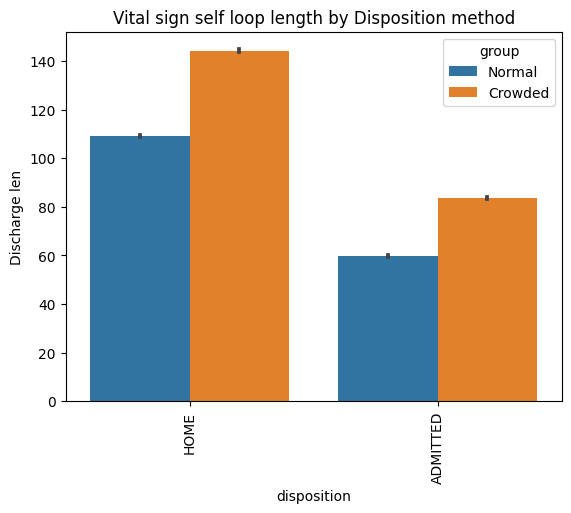

In [29]:
df_t1 = df_loops.loc[(df_loops['activity'] == 'Vital sign check') & (df_loops['activity_next'] == 'Vital sign check') & (df_loops['cr_label'] == 'normal')]
df_t1.groupby('disposition')['loop_len'].median().reset_index()

df_t2 = df_loops.loc[(df_loops['activity'] == 'Vital sign check') & (df_loops['activity_next'] == 'Vital sign check') & (df_loops['cr_label'] == 'high')]
df_t2.groupby('disposition')['loop_len'].median().reset_index()

df_t1['group'] = 'Normal'
df_t2['group'] = 'Crowded'

# Merge the two DataFrames
merged_df = pd.concat([df_t1, df_t2])
merged_df= merged_df.loc[(merged_df['disposition'] == 'ADMITTED')|(merged_df['disposition'] == 'HOME')]

# Create the clustered bar plot using seaborn
sn.barplot(data=merged_df, x='disposition', y='loop_len', hue='group')


# Add labels and title to the plot
plt.xticks(rotation='vertical')
plt.xlabel('disposition')
plt.ylabel('Discharge len')
plt.title('Vital sign self loop length by Disposition method')

In [31]:
merged_df.groupby(['disposition','group'])['loop_len'].mean().reset_index()

,disposition,group,loop_len
0,ADMITTED,Crowded,83.729685
1,ADMITTED,Normal,59.777285
2,HOME,Crowded,144.270033
3,HOME,Normal,109.181937
